In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

In [5]:
base_dir = r'./datasets_1'
train_dir = os.path.join(base_dir , 'train')
test_dir = os.path.join(base_dir , 'test')   

In [6]:
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [7]:
train_ds =  torchvision.datasets.ImageFolder(
        train_dir,
        transform=transform
    )

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: './datasets_1\\train'

In [5]:
test_ds =  torchvision.datasets.ImageFolder(
        test_dir,
        transform=transform
    )

In [6]:
BTACH_SIZE = 32

In [7]:
train_dl = torch.utils.data.DataLoader(
                            train_ds,
                            batch_size=BTACH_SIZE,
                            shuffle=True
)

In [8]:
test_dl = torch.utils.data.DataLoader(
                            test_ds,
                            batch_size=BTACH_SIZE,
)

In [9]:
model = torchvision.models.resnet18(pretrained=True)

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
for param in model.parameters():
    param.requires_grad = False

In [12]:
in_f = model.fc.in_features

In [13]:
model.fc = nn.Linear(in_f, 4)

In [14]:
if torch.cuda.is_available():
    model.to('cuda')

In [15]:
loss_fn = nn.CrossEntropyLoss()

In [16]:
# Decay LR by a factor of 0.1 every 7 epochs
#from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [17]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [18]:
epochs = 50

In [19]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.045 accuracy: 0.321 test_loss：  0.045 test_accuracy: 0.36
epoch:  1 loss：  0.041 accuracy: 0.439 test_loss：  0.041 test_accuracy: 0.484
epoch:  2 loss：  0.037 accuracy: 0.514 test_loss：  0.037 test_accuracy: 0.564
epoch:  3 loss：  0.035 accuracy: 0.576 test_loss：  0.034 test_accuracy: 0.649
epoch:  4 loss：  0.032 accuracy: 0.668 test_loss：  0.032 test_accuracy: 0.729
epoch:  5 loss：  0.03 accuracy: 0.704 test_loss：  0.03 test_accuracy: 0.756
epoch:  6 loss：  0.028 accuracy: 0.742 test_loss：  0.028 test_accuracy: 0.769
epoch:  7 loss：  0.026 accuracy: 0.793 test_loss：  0.026 test_accuracy: 0.787
epoch:  8 loss：  0.025 accuracy: 0.826 test_loss：  0.024 test_accuracy: 0.796
epoch:  9 loss：  0.023 accuracy: 0.846 test_loss：  0.023 test_accuracy: 0.827
epoch:  10 loss：  0.022 accuracy: 0.853 test_loss：  0.022 test_accuracy: 0.849
epoch:  11 loss：  0.021 accuracy: 0.862 test_loss：  0.02 test_accuracy: 0.871
epoch:  12 loss：  0.02 accuracy: 0.869 test_loss：  0.019 test_accu

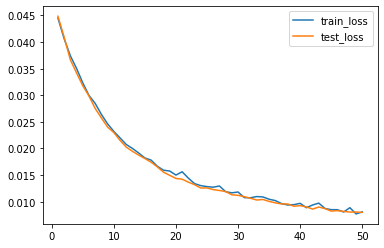

In [20]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

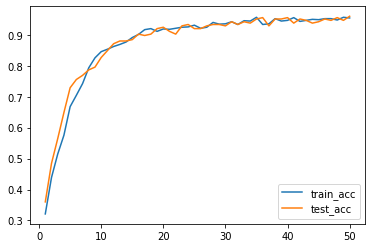

In [21]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()